# Recurrent Neural Network To Predict Stock Price

Using only one attribute of the dataset to make the prediction and predicting multiple outputs.

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
dataset = pd.read_csv('petr4_training.csv')
dataset = dataset.dropna()
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [3]:
dataset_train = dataset.iloc[:, 1:2].values # attribute open
dataset_high = dataset.iloc[:, 2:3].values # attribute high

In [5]:
dataset_high.max(), dataset_train.max()

(24.9, 24.84)

In [6]:
combined_data = np.concatenate((dataset_train, dataset_high), axis=0)

normalizer = MinMaxScaler(feature_range=(0, 1))
normalizer.fit(combined_data)

dataset_train = normalizer.transform(dataset_train)
dataset_high = normalizer.transform(dataset_high)

In [9]:
x, y1, y2 = [], [], []

for i in range(90, 1242):
    x.append(dataset_train[i-90:i, 0])
    y1.append(dataset_train[i, 0])
    y2.append(dataset_high[i, 0])

x, y1, y2 = np.array(x), np.array(y1), np.array(y2)

In [10]:
y = np.column_stack((y1, y2))

In [12]:
x.shape, y.shape

((1152, 90), (1152, 2))

In [15]:
model = Sequential()

model.add(LSTM(units= 100, return_sequences= True, input_shape= (x.shape[1], 1)))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50))
model.add(Dropout(rate= 0.3))

model.add(Dense(units= 2, activation= 'linear'))

c:\Users\Pedro\Documents\codigos\Deep-Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(), loss= 'mean_squared_error', metrics= ['mean_absolute_error'])

In [18]:
# defining callbacks
es = EarlyStopping(monitor= 'loss', patience= 10, verbose= True, min_delta= 1e-10)
rlr = ReduceLROnPlateau(monitor= 'loss', patience= 5, verbose= 1, factor= 0.2)
mcp = ModelCheckpoint(filepath= 'weights.keras', monitor= 'loss', save_best_only= True, verbose= 1)

In [19]:
model.fit(
    x,
    y,
    epochs= 100,
    batch_size= 32,
    callbacks= [es, rlr, mcp]
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0779 - mean_absolute_error: 0.2109
Epoch 1: loss improved from inf to 0.04033, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0769 - mean_absolute_error: 0.2093 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0176 - mean_absolute_error: 0.1029
Epoch 2: loss improved from 0.04033 to 0.01726, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0176 - mean_absolute_error: 0.1029 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0160 - mean_absolute_error: 0.0985
Epoch 3: loss improved from 0.01726 to 0.01446, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0159 - mean_absolute_error: 0.0984 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0122 - mean_absolute_error: 0.0845
Epoch 4: loss improved from 0.01446 to 0.01258, saving 

In [20]:
dataset_test = pd.read_csv('petr4_test.csv')
y_test_open = dataset_test.iloc[:, 1:2].values
y_test_high = dataset_test.iloc[:, 2:3].values

In [21]:
dataset_completed = pd.concat((dataset['Open'], dataset_test['Open']), axis= 0)
inputs = dataset_completed[len(dataset_completed) - len(dataset_test) - 90:].values
inputs = inputs.reshape(-1, 1)
inputs = normalizer.transform(inputs)

In [22]:
inputs

array([[0.47004831],
       [0.46183575],
       [0.46328502],
       [0.45072464],
       [0.46618357],
       [0.47149758],
       [0.50096618],
       [0.50483092],
       [0.52270531],
       [0.52657005],
       [0.51594203],
       [0.52077295],
       [0.51884058],
       [0.52318841],
       [0.52512077],
       [0.52270531],
       [0.52657005],
       [0.53381643],
       [0.56280193],
       [0.55072464],
       [0.55990338],
       [0.56328502],
       [0.55555556],
       [0.53961353],
       [0.54589372],
       [0.53091787],
       [0.55072464],
       [0.56521739],
       [0.56425121],
       [0.55362319],
       [0.55120773],
       [0.57632845],
       [0.57826087],
       [0.57391304],
       [0.58115942],
       [0.57777778],
       [0.57681155],
       [0.58067628],
       [0.57004831],
       [0.5792271 ],
       [0.58405802],
       [0.58405802],
       [0.59565222],
       [0.60772952],
       [0.60724638],
       [0.61690816],
       [0.61352657],
       [0.617

In [24]:
x_test = []

for i in range(90, 112):
    x_test.append(inputs[i-90:i, 0])

x_test = np.array(x_test)

In [25]:
predictions = model.predict(x_test)
predictions = normalizer.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


In [27]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test_open.ravel(), predictions[:, 0]))
print(mean_absolute_error(y_test_high.ravel(), predictions[:, 1]))

0.7363929936800871
0.7416997201094194


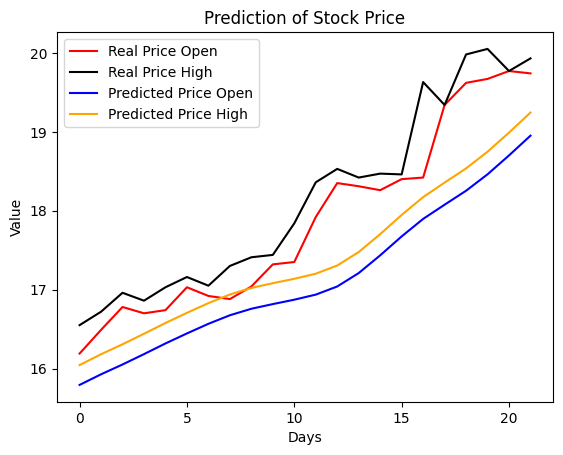

In [29]:
plt.plot(y_test_open, color= 'red', label= 'Real Price Open')
plt.plot(y_test_high, color= 'black', label= 'Real Price High')

plt.plot(predictions[:, 0], color= 'blue', label= 'Predicted Price Open')
plt.plot(predictions[:, 1], color= 'orange', label= 'Predicted Price High')

plt.title('Prediction of Stock Price')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()